<a href="https://colab.research.google.com/github/engineereliab076/my-projects/blob/main/tag_of_QUESTIONS_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Predict the tag for a Stack Overflow question
Download a dataset of programming questions from Stack Overflow. Each question ("How do I sort a dictionary by value?") is labeled with exactly one tag (Python, CSharp, JavaScript, or Java).
Y**our task is to develop a model that predicts the tag for a question**. This is an example of multi-class classification—an important and widely applicable kind of machine learning problem.

In [ ]:
import pathlib
from tensorflow.keras import utils
import tensorflow as tf

In [ ]:
#DOWNLOAD DATA

data_url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'

dataset_dir = utils.get_file(
    origin=data_url,
    untar=True,
    cache_dir='stack_overflow',
    cache_subdir='')
dataset_dir = pathlib.Path(dataset_dir).parent

In [ ]:
#get list of all directories in a file
list(dataset_dir.iterdir())

[PosixPath('/tmp/.keras/stack_overflow_16k.tar.gz'),
 PosixPath('/tmp/.keras/README.md'),
 PosixPath('/tmp/.keras/test'),
 PosixPath('/tmp/.keras/train')]

In [ ]:
#get files in train direc
train_dir = dataset_dir/'train'
list(train_dir.iterdir())

[PosixPath('/tmp/.keras/train/python'),
 PosixPath('/tmp/.keras/train/java'),
 PosixPath('/tmp/.keras/train/javascript'),
 PosixPath('/tmp/.keras/train/csharp')]

In [ ]:
#print sample file

sample_file = train_dir/'java/1.txt'

with open(sample_file) as f:
  print(f.read())

"add version to @@webservice i'm using blankx.jws.webservice to create my webservice, in addition to targetnamespace i would like to include a ""version"" attribute to mark the version of my service. what other tag can i use in addition to this one to accomplish this so my wdsl will look like:..&lt;schema targetnamespace=""http://example.com/2009/02/15/webservice"" version=""1.1"" xmlns=""http://www.w3.org/2000/10/xmlschema&gt;...i.e. it has a version attribute"



In [ ]:
#Load the dataset-load the data off-disk and prepare it into a format suitable for training
#Create a validation set using an 80:20 split of the training data by using

batch_size=32
seed=42

raw_train_ds =utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


As the previous cell output suggests, there are 8,000 examples in the training folder, of which you will use 80% (or 6,400) for training. You will learn in a moment that you can train a model by passing a tf.data.Dataset directly to Model.fit.

In [ ]:
raw_train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
#print first 10 labels and questions
for text_batch,label_batch in raw_train_ds.take(1):
  for i in range(10):
    print('Question:',text_batch.numpy()[i])
    print('Label:',label_batch.numpy()[i])

Question: b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default cons

In [ ]:
for i, label in enumerate(raw_train_ds.class_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [ ]:
#create a validation set
raw_validation_ds = utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    seed=seed,
    validation_split=0.2,
    subset='validation'
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [ ]:
#create a test ds

test_dir = dataset_dir/'test'

raw_test_ds = utils.text_dataset_from_directory(
    test_dir,batch_size=batch_size
)

Found 8000 files belonging to 4 classes.


DATASET CONFIGURATION

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

Dataset.cache keeps data in memory after it's loaded off-disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.
Dataset.prefetch overlaps data preprocessing and model execution while training.

In [ ]:
raw_train_ds = raw_train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
raw_validation_ds = raw_validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
raw_test_ds = raw_test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Prepare the dataset for training

In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
#standardization, tokenization and vectorization
#All of these tasks can be accomplished with this layer - tf.keras.layers.TextVectorization
VOCAB_SIZE=10000

binary_vectorizer_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='binary'
)

MAX_SEQUENCE_LENGTH = 250

int_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)


In [ ]:
#make text only dataset then call textvectorizer.adapt

train_text= raw_train_ds.map(lambda text,labels:text)
binary_vectorizer_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)

In [ ]:
# Retrieve a batch (of 32 reviews and labels) from the dataset.
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question:", first_question)
print("Label:", first_label)

Question: tf.Tensor(b'"unit testing of setters and getters teacher wanted us to do a comprehensive unit test. for me, this will be the first time that i use junit. i am confused about testing set and get methods. do you think should i test them? if the answer is yes; is this code enough for testing?..  public void testsetandget(){.    int a = 10;.    class firstclass = new class();.    firstclass.setvalue(10);.    int value = firstclass.getvalue();.    assert.asserttrue(""error"", value==a);.  }...in my code, i think if there is an error, we can\'t know that the error is deriving because of setter or getter."\n', shape=(), dtype=string)
Label: tf.Tensor(1, shape=(), dtype=int32)


In [ ]:
print("'binary' vectorized question:",
      list(binary_vectorizer_layer(first_question).numpy()))

'binary' vectorized question: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0,

In [ ]:
print("'int' vectorized question:",
      int_vectorize_layer(first_question).numpy())

'int' vectorized question: [1011  773    9 2456    8 1863 2362  690 1267    4   40    5    1 1011
  196   12   74   13   72   33    2   98  105   14    3   70 9611    3
   34  888  202  773  107    8   41  242   40   58  291   90    3  196
  191   10    2  182    6  668    6   13   30 1187   12  773   22   42
    1   28    5  140   29 5213   15   29    1   28   51    1    1    1
    7   23   30    3  291   10   67    6   32   65  185  166  102   14
    2   65    6    1  193    9 2784   45 2410    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0

In [ ]:
#lookup the token (string) that each integer corresponds to by calling TextVectorization.get_vocabulary on the layer:

print("1289 ---> ", int_vectorize_layer.get_vocabulary()[1289])
print("313 ---> ", int_vectorize_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(int_vectorize_layer.get_vocabulary())))

1289 --->  roman
313 --->  source
Vocabulary size: 10000


MODEL TRAINING

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import losses
import matplotlib.pyplot as plt

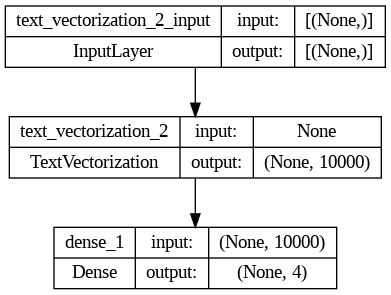

In [ ]:
#For the 'binary' vectorized data, define a simple bag-of-words linear model, then configure and train it

binary_model = tf.keras.Sequential([
    binary_vectorizer_layer,
    layers.Dense(4)])

binary_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])
tf.keras.utils.plot_model(binary_model, show_shapes=True)

In [ ]:
bin_history = binary_model.fit(
    raw_train_ds, validation_data=raw_validation_ds, epochs=10)

print()

Epoch 1/10
200/200 [==============================] - 3s 11ms/step - loss: 1.1206 - accuracy: 0.6391 - val_loss: 0.9180 - val_accuracy: 0.7819
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 0.7801 - accuracy: 0.8170 - val_loss: 0.7534 - val_accuracy: 0.8000
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 0.6284 - accuracy: 0.8602 - val_loss: 0.6670 - val_accuracy: 0.8144
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 0.5347 - accuracy: 0.8880 - val_loss: 0.6131 - val_accuracy: 0.8244
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 0.4686 - accuracy: 0.9031 - val_loss: 0.5761 - val_accuracy: 0.8294
Epoch 6/10
200/200 [==============================] - 1s 7ms/step - loss: 0.4182 - accuracy: 0.9173 - val_loss: 0.5492 - val_accuracy: 0.8331
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: 0.3779 - accuracy: 0.9277 - val_loss: 0.5289 - val_accuracy: 0.8356
Epoch

In [ ]:
#Next, you will use the 'int' vectorized layer to build a 1D ConvNet

def create_model(vocab_size, num_labels, vectorizer=None):
  my_layers =[]
  if vectorizer is not None:
    my_layers = [vectorizer]

  my_layers.extend([
      layers.Embedding(vocab_size, 64, mask_zero=True),
      layers.Dropout(0.5),
      layers.Conv1D(64, 5, padding="valid", activation="relu", strides=2),
      layers.GlobalMaxPooling1D(),
      layers.Dense(num_labels)
  ])

  model = tf.keras.Sequential(my_layers)
  return model

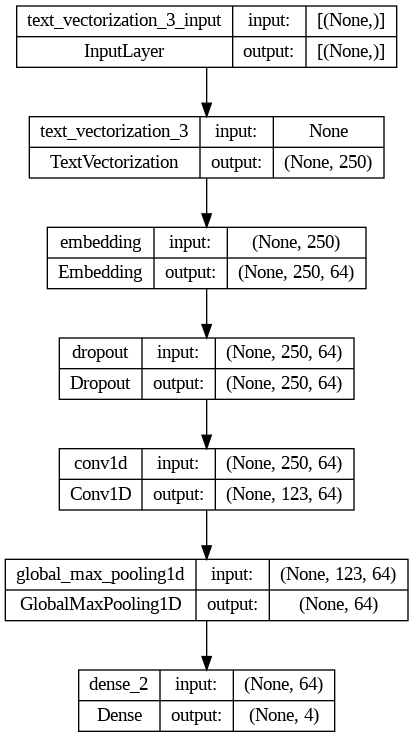

In [ ]:
# `vocab_size` is `VOCAB_SIZE + 1` since `0` is used additionally for padding.
int_model = create_model(vocab_size=VOCAB_SIZE + 1, num_labels=4, vectorizer=int_vectorize_layer)

tf.keras.utils.plot_model(int_model, show_shapes=True)

In [ ]:
int_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])
int_history = int_model.fit(raw_train_ds, validation_data=raw_validation_ds, epochs=10)

Epoch 1/10
200/200 [==============================] - 9s 41ms/step - loss: 1.2751 - accuracy: 0.4120 - val_loss: 0.9400 - val_accuracy: 0.6056
Epoch 2/10
200/200 [==============================] - 7s 33ms/step - loss: 0.7854 - accuracy: 0.6716 - val_loss: 0.6504 - val_accuracy: 0.7325
Epoch 3/10
200/200 [==============================] - 7s 35ms/step - loss: 0.5712 - accuracy: 0.7812 - val_loss: 0.5391 - val_accuracy: 0.7925
Epoch 4/10
200/200 [==============================] - 7s 33ms/step - loss: 0.4134 - accuracy: 0.8641 - val_loss: 0.4831 - val_accuracy: 0.8150
Epoch 5/10
200/200 [==============================] - 7s 36ms/step - loss: 0.2920 - accuracy: 0.9102 - val_loss: 0.4717 - val_accuracy: 0.8163
Epoch 6/10
200/200 [==============================] - 8s 40ms/step - loss: 0.2109 - accuracy: 0.9398 - val_loss: 0.4917 - val_accuracy: 0.8194
Epoch 7/10
200/200 [==============================] - 8s 40ms/step - loss: 0.1472 - accuracy: 0.9614 - val_loss: 0.5166 - val_accuracy: 0.8150

Text(0, 0.5, 'CE/token')

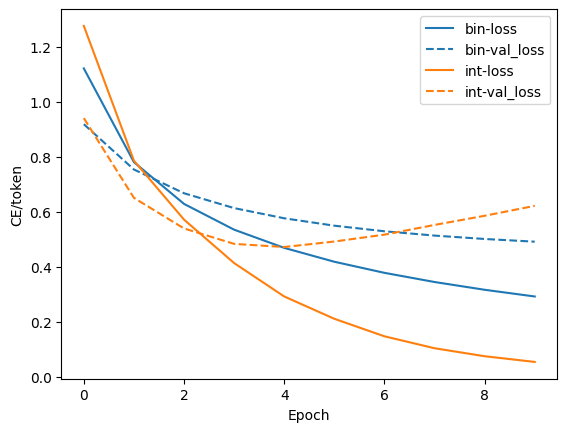

In [ ]:
loss = plt.plot(bin_history.epoch, bin_history.history['loss'], label='bin-loss')
plt.plot(bin_history.epoch, bin_history.history['val_loss'], '--', color=loss[0].get_color(), label='bin-val_loss')

loss = plt.plot(int_history.epoch, int_history.history['loss'], label='int-loss')
plt.plot(int_history.epoch, int_history.history['val_loss'], '--', color=loss[0].get_color(), label='int-val_loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('CE/token')

In [ ]:
binary_model.export('bin.tf')

Saved artifact at 'bin.tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None,), dtype=tf.string, name='text_vectorization_2_input')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  136213287413968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136213237746144: TensorSpec(shape=(), dtype=tf.int64, name=None)
  136213236496544: TensorSpec(shape=(), dtype=tf.string, name=None)
  136213236497072: TensorSpec(shape=(), dtype=tf.int64, name=None)
  136213236677296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136213236662688: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
loaded = tf.saved_model.load('bin.tf')

In [ ]:
binary_model.predict(['How do you sort a list?'])

1/1 [==============================] - 0s 148ms/step


array([[-0.11646075,  0.02594102, -0.6090005 ,  0.40103528]],
      dtype=float32)

In [ ]:
loaded.serve(tf.constant(['How do you sort a list?'])).numpy()

array([[-0.11646075,  0.02594102, -0.6090005 ,  0.40103528]],
      dtype=float32)